In [2080]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1272]:
df = pd.read_csv('/Users/t2023-m0124/Library/CloudStorage/OneDrive-고려사이버대학교/[자격증] ADP/스터디/smart_city_data.csv')
df.head()

,timestamp,is_holiday,hour_of_day,day_of_week,month,season,temperature,humidity,wind_speed,aqi,...,aqi_trend,traffic,traffic_intensity,congestion,congestion_duration,energy_consumption,energy_mean,energy_std,energy_anomaly,cumulative_energy
0,2022-01-01 00:00:00,1,0,5,1,winter,16.490142,83.081043,5.240700,108.087306,...,0.000000,193.992712,0.551381,False,0,2432.855230,2868.927127,677.021730,0,2432.855230
1,2022-01-01 01:00:00,1,1,5,1,winter,14.595967,50.975153,6.440914,93.982166,...,-6.980342,300.727771,0.721670,False,0,2508.150308,3165.802996,658.025437,0,4941.005539
2,2022-01-01 02:00:00,1,2,5,1,winter,16.964586,50.222117,3.282828,92.901503,...,-5.514599,232.585031,0.478316,False,0,2208.624810,3573.198461,917.720707,0,7149.630349
3,2022-01-01 03:00:00,1,3,5,1,winter,19.601370,74.082277,8.391032,91.374001,...,-5.396465,276.089671,0.469658,False,0,2968.122196,3839.320253,941.483599,0,10117.752545
4,2022-01-01 04:00:00,1,4,5,1,winter,14.340580,69.694355,0.905666,91.832702,...,-3.976381,368.476045,0.580955,False,0,3867.308716,3983.463882,1020.648019,0,13985.061261


### 1. 데이터 전처리 및 특성 공학 (25점)

1.1 시간 관련 특성 생성

다음 시간 관련 특성들을 생성하세요: a) hour_of_day: 0-23 b) day_of_week: 0(월요일)-6(일요일) c) month: 1-12 d) season: 'spring', 'summer', 'fall', 'winter' e) is_holiday: 공휴일이면 1, 아니면 0 (공휴일 목록은 별도로 제공됨)

- timestamp 변수 datetime 형식 변환 

In [1278]:
df.timestamp = pd.to_datetime(df.timestamp)

In [1280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            8760 non-null   datetime64[ns]
 1   is_holiday           8760 non-null   int64         
 2   hour_of_day          8760 non-null   int64         
 3   day_of_week          8760 non-null   int64         
 4   month                8760 non-null   int64         
 5   season               8760 non-null   object        
 6   temperature          8760 non-null   float64       
 7   humidity             8760 non-null   float64       
 8   wind_speed           8760 non-null   float64       
 9   aqi                  8760 non-null   float64       
 10  aqi_category         8760 non-null   object        
 11  aqi_ma24             8760 non-null   float64       
 12  aqi_trend            8760 non-null   float64       
 13  traffic              8760 non-nul

In [1282]:
df['hour_of_day'] = df.timestamp.dt.hour

In [1284]:
df['day_of_week'] = df.timestamp.dt.day_of_week

In [1286]:
df['month'] = df.timestamp.dt.month

In [1288]:
def season(x):
    if x >= 1 and x <= 3:
        return 'spring'
    elif x >= 4 and x <= 6:
        return 'summer'
    elif x >= 7 and x <= 9:
        return 'fall'
    else:
        return 'winter'

In [1290]:
df['season'] = df.month.map(season)

In [1292]:
holidays = [
    '2022-01-01', '2022-01-17', '2022-02-21', '2022-05-30', '2022-07-04', 
    '2022-09-05', '2022-11-24', '2022-12-25'
]

In [1294]:
df['is_holiday'] = df.timestamp.map(lambda x : 1 if x.strftime('%Y-%m-%d') in holidays else 0)

1.2 대기 질 지수(AQI) 관련 특성 생성

대기 질 지수(AQI)를 기반으로 다음 특성을 생성하세요:

a) aqi_category: AQI < 50 'Good', 50-100 'Moderate', 100-150 'Unhealthy for Sensitive Groups', > 150 'Unhealthy'

b) aqi_trend: 이전 24시간 동안의 AQI 변화율 (%)

In [1298]:
def aqi_cat(x):
    if x < 50:
        return 'Good'
    elif x >= 50 and x < 100:
        return 'Moderate'
    elif x >= 100 and x < 150:
        return 'Unhealthy for Sensitive Groups'
    else:
        return 'Unhealthy'

In [1300]:
df['aqi_category'] = df.aqi.map(aqi_cat)

In [1302]:
df['aqi_trend'] = df.aqi.diff(24) / df.aqi

1.3 교통 데이터 관련 특성 생성

교통 데이터를 사용하여 다음 특성을 생성하세요:

a) traffic_intensity: 현재 교통량을 해당 시간대의 평균 교통량으로 나눈 비율

b) congestion_duration: 교통 체증(traffic_intensity > 1.5)이 지속된 연속 시간

In [1306]:
df['traffic_hour_mean'] = df.groupby('hour_of_day').traffic.transform('mean')

In [1308]:
df['traffic_intensity'] = df.traffic / df.traffic_hour_mean

In [1310]:
df.drop(columns = 'traffic_hour_mean', inplace = True)

In [1312]:
count_lst = []
count = 0

for i in range(1, len(df)):
    if df.traffic_intensity.iloc[i] > 1.5 and df.traffic_intensity.iloc[i-1] > 1.5:
        count += 1
    else:
        count = 0
    count_lst.append(count)

In [1314]:
count_lst = [0] + count_lst

In [1316]:
df['congestion_duration'] = count_lst

1.4 에너지 소비 데이터 관련 특성 생성

에너지 소비 데이터를 사용하여 다음 특성을 생성하세요:

a) energy_anomaly: 현재 에너지 소비량이 같은 요일, 같은 시간대의 평균보다 2표준편차 이상 높으면 1, 아니면 0

b) cumulative_energy: 해당 일자의 자정부터 현재 시간까지의 누적 에너지 소비량

In [1320]:
df.loc[df.energy_consumption > df.groupby(['day_of_week','hour_of_day']).energy_consumption.transform('mean') + df.energy_std * 2, 'energy_anomaly'] = 1
df.loc[~(df.energy_consumption > df.groupby(['day_of_week','hour_of_day']).energy_consumption.transform('mean') + df.energy_std * 2), 'energy_anomaly'] = 0

In [1322]:
df['cumulative_energy'] = df.groupby(df.timestamp.dt.date).energy_consumption.cumsum()

1.5 결측치와 이상치 처리

위에서 생성한 특성들을 포함하여 전체 데이터셋의 결측치와 이상치를 처리하세요. 처리 방법과 그 이유를 설명하세요.

- 결측치는 aqi_trend, traffic_intensity 변수에서 확인된다.
  - aqi_trend의 결측치는 이전 24시간동안의 aqi를 이용하기때문에 초기값이 계산이 되지 않아 발생한 것으로 판단되므로 갯수가 많지 않고 대체 시 분석결과를 왜곡할 수 있으므로 삭제한다.
  - traffic_intensity의 결측치는 실제 측정된 교통량이 0으로 평균 교통량 또한 0이기때문에 나타난 값으로 판단되므로 0으로 처리한다.

In [1327]:
df.loc[df.traffic_intensity.isnull()].head()

,timestamp,is_holiday,hour_of_day,day_of_week,month,season,temperature,humidity,wind_speed,aqi,...,aqi_trend,traffic,traffic_intensity,congestion,congestion_duration,energy_consumption,energy_mean,energy_std,energy_anomaly,cumulative_energy
18,2022-01-01 18:00:00,1,18,5,1,spring,12.469604,89.889064,5.921578,66.968765,...,NaN,0.0,NaN,False,0,888.834332,1628.326621,375.796062,0,41482.806021
42,2022-01-02 18:00:00,0,18,6,1,spring,15.104911,77.344608,5.094209,108.547913,...,0.383049,0.0,NaN,False,0,1508.988618,1621.789453,347.532924,0,57217.981133
66,2022-01-03 18:00:00,0,18,0,1,spring,15.493871,53.284928,3.375686,77.222724,...,-0.405647,0.0,NaN,False,0,2204.064460,2098.236207,566.824297,0,68539.579489
90,2022-01-04 18:00:00,0,18,1,1,spring,16.258970,96.777028,2.917137,93.856177,...,0.177223,0.0,NaN,False,0,2057.463586,2161.421779,492.628978,0,72652.675002
114,2022-01-05 18:00:00,0,18,2,1,spring,15.648203,76.301320,4.593687,58.299172,...,-0.609906,0.0,NaN,False,0,1997.107520,2012.916842,476.150442,0,65125.877434


In [1329]:
df2 = df.loc[df.aqi_trend.notnull()].fillna(0).reset_index(drop = True)

### 2. 탐색적 데이터 분석 (EDA) (20점)

2.1 변수 간 상관관계 분석

대기 질, 교통 흐름, 에너지 소비 간의 상관관계를 분석하세요. 최소 3개의 다른 시각화 기법을 사용하여 결과를 표현하세요.

- 변수 간 산점도, 상관관계행렬 시각화, 상관관계 높은 순 막대그래프를 그린다.
  - 분석 결과 traffic과 energy_consumption의 상관관계가 가장 높은 것으로 나타난다.

In [1335]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8735 entries, 0 to 8734
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            8735 non-null   datetime64[ns]
 1   is_holiday           8735 non-null   int64         
 2   hour_of_day          8735 non-null   int32         
 3   day_of_week          8735 non-null   int32         
 4   month                8735 non-null   int32         
 5   season               8735 non-null   object        
 6   temperature          8735 non-null   float64       
 7   humidity             8735 non-null   float64       
 8   wind_speed           8735 non-null   float64       
 9   aqi                  8735 non-null   float64       
 10  aqi_category         8735 non-null   object        
 11  aqi_ma24             8735 non-null   float64       
 12  aqi_trend            8735 non-null   float64       
 13  traffic              8735 non-nul

In [1337]:
target = df2[['aqi','traffic','energy_consumption']]

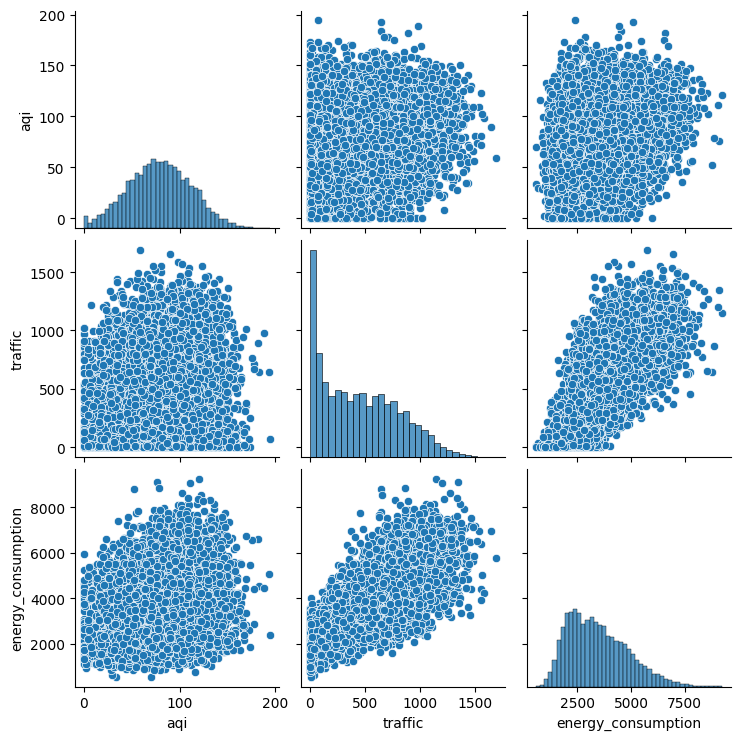

In [1339]:
sns.pairplot(target)
plt.show()

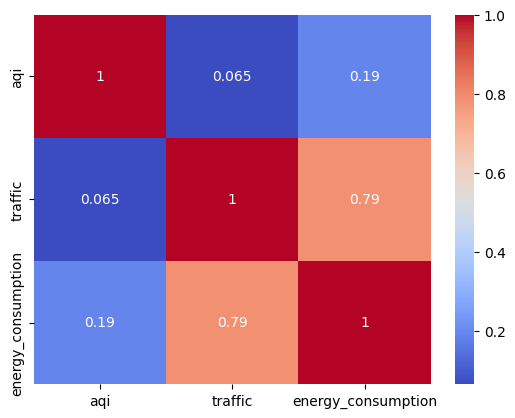

In [1341]:
sns.heatmap(target.corr(), cmap = 'coolwarm', annot = True)
plt.show()

In [1343]:
from itertools import combinations

In [1345]:
col_name = []
corr_lst = []
for col1, col2 in combinations(target.columns, 2):
    col_name.append(f'{col1}-{col2}')
    corr_lst.append(target[[col1, col2]].corr().iloc[0,1])

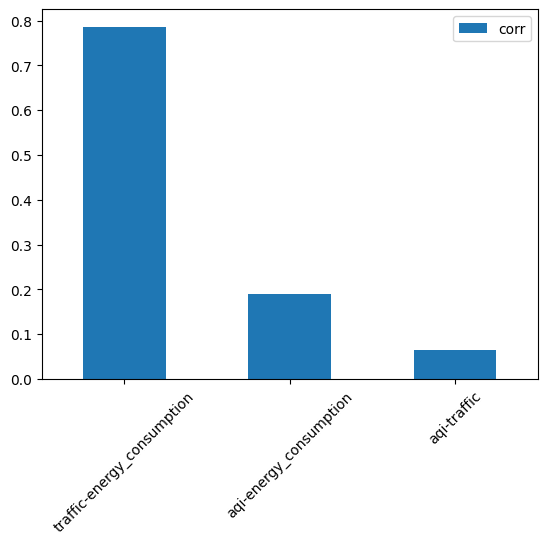

In [1347]:
pd.DataFrame(corr_lst, index = col_name, columns = ['corr']).sort_values(by = 'corr', ascending = False).plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.show()

2.2 시간적 패턴 분석

계절별, 요일별 패턴을 분석하세요. 각 주요 변수(AQI, 교통량, 에너지 소비)에 대해 히트맵을 생성하여 시간적 패턴을 시각화하세요.

- api의 경우 spring과 summer에 집중되는 경향이 확인되나 요일별로는 큰 차이는 확인되지 않는다.
- traffic의 경우 월요일부터 금요일까지 집중되는 경향이 확인되며 summer에 집중되는 경향이 확인된다.
- energy의 경우 spring과 summer에 집중되며 월요일에서 금요일까지 집중되는 경향이 확인된다.

In [1352]:
target = df2[['season','day_of_week','aqi','traffic','energy_consumption']]

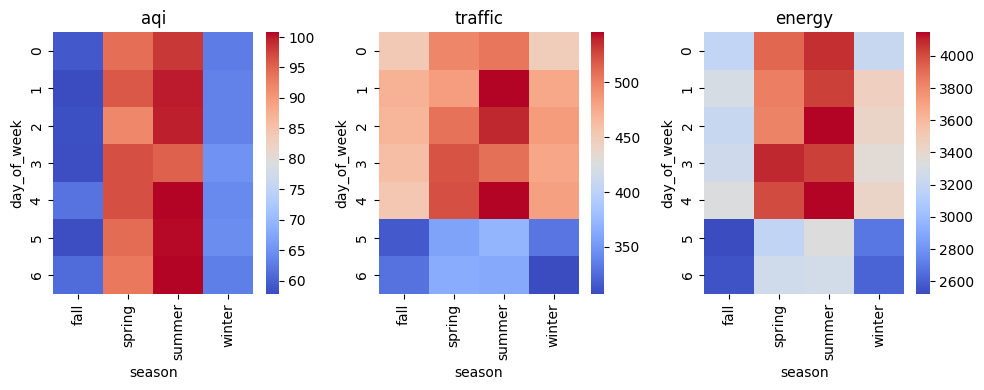

In [1354]:
plt.figure(figsize = (10, 4))
plt.subplot(131)
sns.heatmap(target.groupby(['season','day_of_week']).aqi.mean().unstack(0), cmap = 'coolwarm')
plt.title('aqi')
plt.subplot(132)
sns.heatmap(target.groupby(['season','day_of_week']).traffic.mean().unstack(0), cmap = 'coolwarm')
plt.title('traffic')
plt.subplot(133)
sns.heatmap(target.groupby(['season','day_of_week']).energy_consumption.mean().unstack(0), cmap = 'coolwarm')
plt.title('energy')
plt.tight_layout()

2.3 공휴일 영향 분석

공휴일이 대기 질, 교통 흐름, 에너지 소비에 미치는 영향을 분석하세요. 통계적 검정을 사용하여 차이의 유의성을 확인하세요.

- 각 변수를 종속변수로 설정하고 공휴일을 독립변수로 설정한 후 회귀분석을 하여 통계적 유의성을 검정한다.
- 검정 결과 각 종속변수별로 공휴일 여부의 p-value가 0.05 미만으로 통계적으로 유의미한 차이를 보이는 것으로 확인된다.

In [1359]:
import statsmodels.api as sm

In [1361]:
aqi_ols = sm.OLS(endog = df2.aqi, exog=df2.is_holiday).fit()

In [1363]:
traffic_ols = sm.OLS(endog = df2.traffic, exog=df2.is_holiday).fit()

In [1365]:
energy_ols = sm.OLS(endog = df2.energy_consumption, exog=df2.is_holiday).fit()

In [1367]:
aqi_ols.pvalues

is_holiday    7.688644e-33
dtype: float64

In [1369]:
traffic_ols.pvalues

is_holiday    9.213449e-24
dtype: float64

In [1371]:
energy_ols.pvalues

is_holiday    1.310284e-30
dtype: float64

2.4 기상 조건과 주요 변수 관계 분석

기상 조건(기온, 습도, 풍속 등)과 주요 변수들 간의 관계를 분석하세요. 비선형적 관계도 고려하여 적절한 시각화 방법을 선택하세요.

- 기상 조건과 aqi, traffic, energy_consumption 변수의 관계를 산점도로 표현하면
  - temparature은 aqi와 양의 상관관계, humidity는 aqi와 음의 상관관계를 보이는 것이 확인된다.

In [1376]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8735 entries, 0 to 8734
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            8735 non-null   datetime64[ns]
 1   is_holiday           8735 non-null   int64         
 2   hour_of_day          8735 non-null   int32         
 3   day_of_week          8735 non-null   int32         
 4   month                8735 non-null   int32         
 5   season               8735 non-null   object        
 6   temperature          8735 non-null   float64       
 7   humidity             8735 non-null   float64       
 8   wind_speed           8735 non-null   float64       
 9   aqi                  8735 non-null   float64       
 10  aqi_category         8735 non-null   object        
 11  aqi_ma24             8735 non-null   float64       
 12  aqi_trend            8735 non-null   float64       
 13  traffic              8735 non-nul

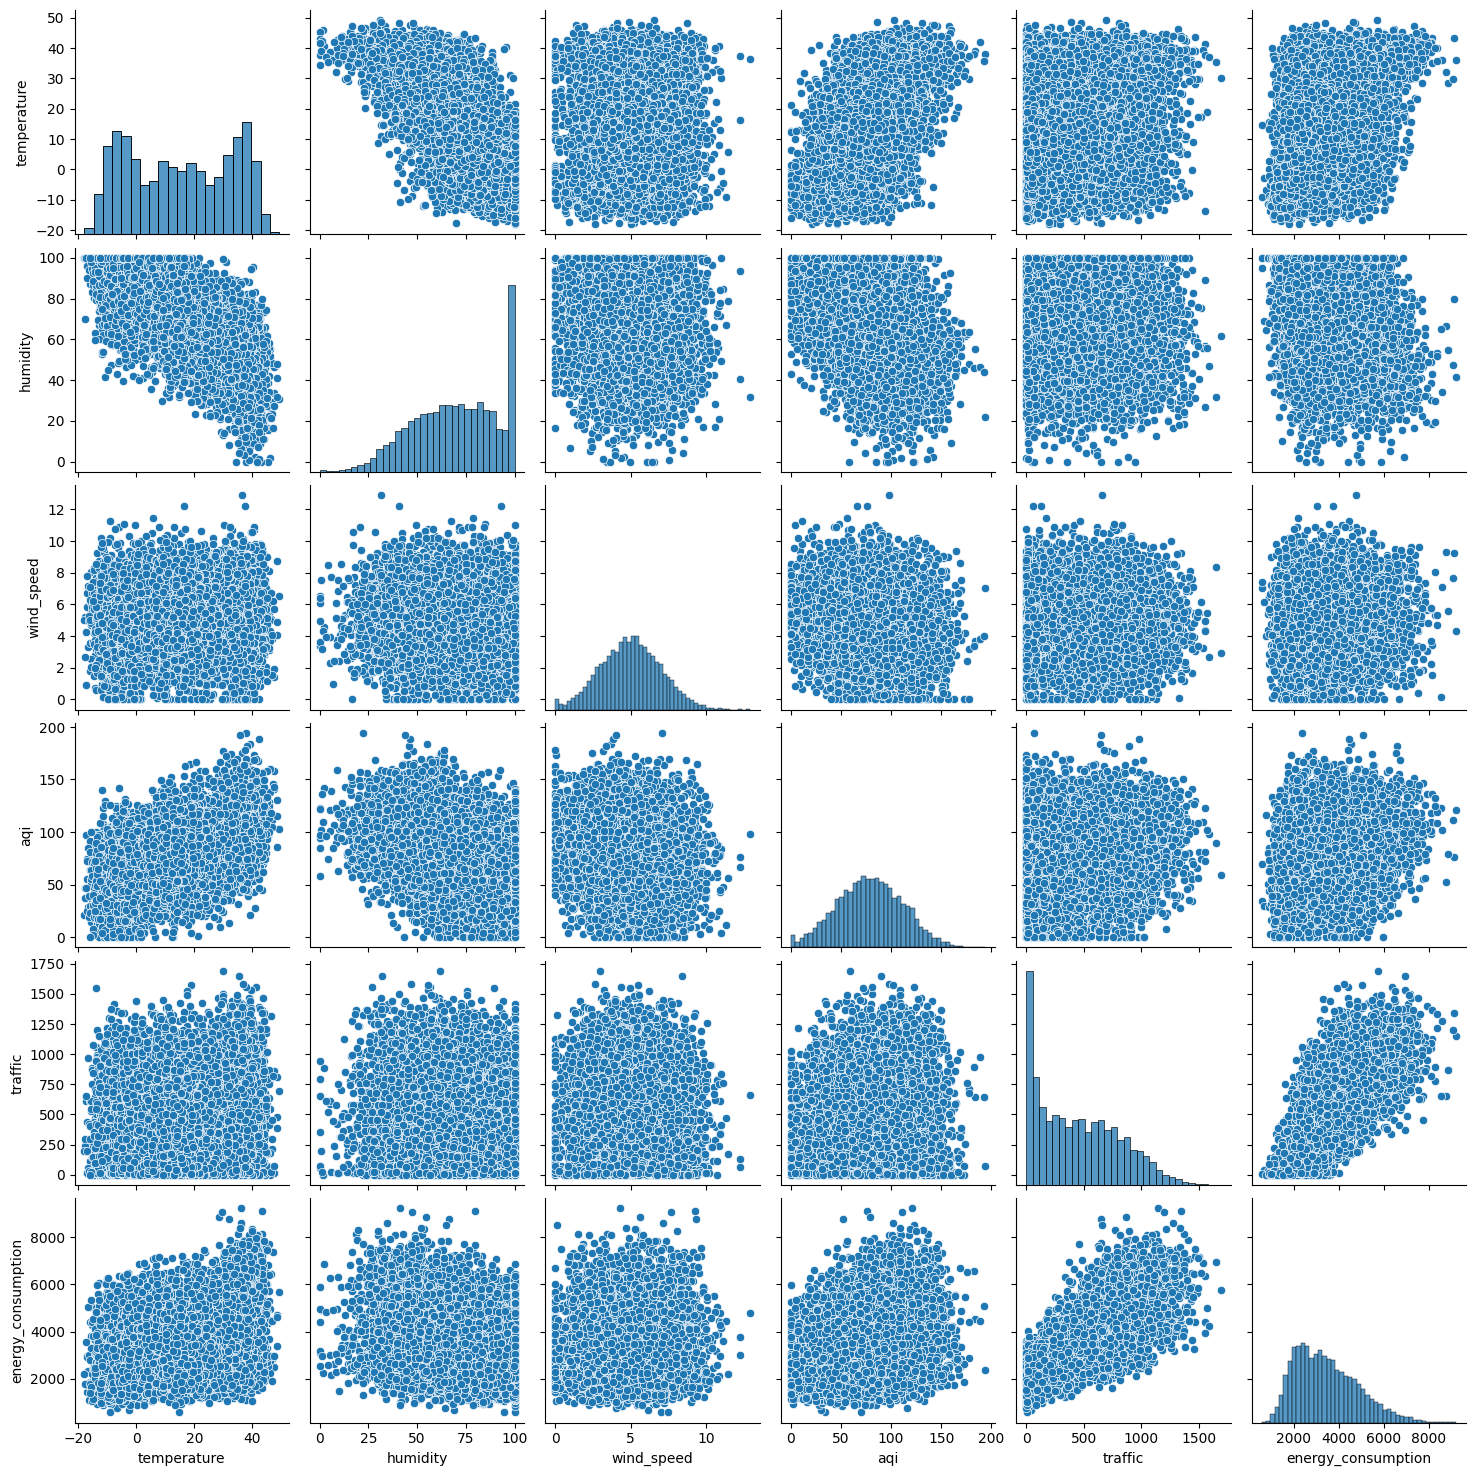

In [847]:
sns.pairplot(df2[['temperature','humidity','wind_speed','aqi','traffic','energy_consumption']])

### 3. 예측 모델링 (35점)

3.1 AQI 예측 모델 개발


다음 24시간 동안의 시간별 AQI를 예측하는 모델을 개발하세요. 다음 두 가지 접근 방식을 비교하세요:

a) 전통적인 시계열 모델 (예: ARIMA, Prophet)

b) 머신러닝 모델 (예: Random Forest, LSTM) 각 모델의 성능을 평가하고, 장단점을 논의하세요.


In [1401]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8735 entries, 2022-01-02 00:00:00 to 2022-12-31 23:00:00
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           8735 non-null   int64  
 1   hour_of_day          8735 non-null   int32  
 2   day_of_week          8735 non-null   int32  
 3   month                8735 non-null   int32  
 4   season               8735 non-null   object 
 5   temperature          8735 non-null   float64
 6   humidity             8735 non-null   float64
 7   wind_speed           8735 non-null   float64
 8   aqi                  8735 non-null   float64
 9   aqi_category         8735 non-null   object 
 10  aqi_ma24             8735 non-null   float64
 11  aqi_trend            8735 non-null   float64
 12  traffic              8735 non-null   float64
 13  traffic_intensity    8735 non-null   float64
 14  congestion           8735 non-null   bool   
 15  co

- 학습데이터, 시험데이터 분리
    - 탐색적 데이터분석에서 유의미한 것으로 판단되는 주요 변수로 데이터를 구성한다.
    - 시계열데이터이므로 1~9월 데이터를 학습데이터로, 10월 이후를 시험데이터로 구성한다.

In [1459]:
df3 = df2.drop(columns = ['aqi_category','aqi_ma24','aqi_trend','congestion']).set_index('timestamp')

In [1461]:
df3 = pd.get_dummies(df3)

In [1463]:
train_df = df3.loc[:pd.to_datetime('2022-10-01')]
test_df = df3.loc[pd.to_datetime('2022-10-01'):]

In [1465]:
X_train = train_df.drop(columns = 'aqi')
X_test = test_df.drop(columns = 'aqi')
y_train = train_df.aqi
y_test = test_df.aqi

- ARIMA 모델 적합
  - 독립변수 없이 종속변수의 시계열적 데이터 요인(추세, 계절성, 오차)만을 이용하여 모델링하는 방법이다.
  - 적합 결과 AR항인 p은 0, 차분은 1차 차분, MA항인 q는 1이 적합한 것으로 나타난다.

In [857]:
from pmdarima import auto_arima

In [1429]:
arima_model = auto_arima(y = y_train)

In [1431]:
arima_model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

- Random Forest 회귀모형 적합
  - 배깅 앙상블 모델링 방법으로, 학습데이터 내 반복추출하여 여러 개의 모델을 만들고 이를 결합하여 모델 성능을 향상시킨다.
  - 모형 적합에 앞서 명목형 변수 분석을 위해 One-hot Encoding해준다.

In [862]:
from sklearn.ensemble import RandomForestRegressor

In [1433]:
rf_model = RandomForestRegressor()

In [1435]:
rf_model.fit(y = y_train, X = X_train)

RandomForestRegressor()

- 모델 성능평가: 시험데이터에 대해서 MSE를 구한다.
  - MSE는 평균제곱오차로 값이 낮을수록 예측력이 좋은 모델로 평가한다.
  - 비교 결과 랜덤포레스트 회귀모형의 예측력이 ARIMA모델에 비해 우수한 것으로 평가된다.

In [1437]:
from sklearn.metrics import mean_squared_error

In [1443]:
arima_pred = arima_model.predict(len(X_test))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [1445]:
arima_pred

6528    51.23617
6529    51.23617
6530    51.23617
6531    51.23617
6532    51.23617
          ...   
8731    51.23617
8732    51.23617
8733    51.23617
8734    51.23617
8735    51.23617
Length: 2208, dtype: float64

In [1447]:
rf_pred = rf_model.predict(X_test)

In [1449]:
mse_arima = mean_squared_error(y_test, arima_pred)

In [1451]:
mse_rf = mean_squared_error(y_test, rf_pred)

In [1453]:
mse_arima, mse_rf

(916.4878575064961, 724.4566712212306)

### 3.2 교통 체증 예측 모델 개발

교통 체증(traffic_intensity > 1.5)이 발생할 확률을 예측하는 분류 모델을 개발하세요. 다음 세 가지 모델을 비교하세요:

a) 로지스틱 회귀

b) Random Forest

c) Gradient Boosting (예: XGBoost, LightGBM)

ROC 커브와 precision-recall 커브를 사용하여 모델들을 평가하고 비교하세요.

- ROC커브를 이용한 모델 비교 결과 XGBoost > Random Forest > 로지스틱 분류모형 순으로 성능이 우수한 것으로 판단된다.

In [986]:
# ! pip install xgboost

In [1467]:
traffic_int_yn = df3.traffic_intensity.map(lambda x : 1 if x > 1.5 else 0)

In [1469]:
X_train, X_test, y_train, y_test = train_test_split(df3, traffic_int_yn, test_size=0.3, stratify=traffic_int_yn, random_state=42)

In [1471]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [1527]:
lr_model = LogisticRegression(max_iter=1000000)

In [1475]:
rf_cf_model = RandomForestClassifier()

In [1477]:
xgb_cf_model = XGBClassifier()

In [1529]:
lr_model.fit(X = X_train, y = y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000000)

In [1507]:
rf_cf_model.fit(X = X_train, y = y_train)

RandomForestClassifier()

In [1508]:
xgb_cf_model.fit(X = X_train, y = y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1531]:
lr_pred = lr_model.predict(X_test)

In [1533]:
rf_pred = rf_cf_model.predict(X_test)

In [1535]:
xgb_pred = xgb_cf_model.predict(X_test)

In [1537]:
from sklearn.metrics import roc_curve, auc

In [1560]:
def draw_roc_curve(y_pred):
    fpr, tpr, thres = roc_curve(y_test, y_pred, pos_label=1)
    plt.plot(fpr, tpr)
    plt.text(s = f'auc = {round(auc(fpr, tpr), 2)}', x = 0.5, y = 0.2)

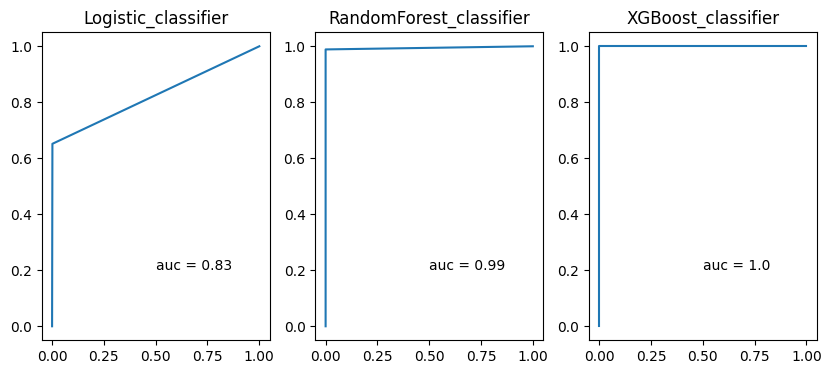

In [1562]:
plt.figure(figsize = (10, 4))
plt.subplot(131)
draw_roc_curve(lr_pred)
plt.title('Logistic_classifier')
plt.subplot(132)
draw_roc_curve(rf_pred)
plt.title('RandomForest_classifier')
plt.subplot(133)
draw_roc_curve(xgb_pred)
plt.title('XGBoost_classifier')
plt.show()

3.3 에너지 소비량 예측 모델 개발

일일 총 에너지 소비량을 예측하는 회귀 모델을 개발하세요. 다음 작업을 수행하세요:

a) 특성 중요도를 평가하고, 상위 10개 특성을 시각화하세요.

b) 교차 검증을 사용하여 모델의 안정성을 평가하세요.

c) 예측 구간을 제공하는 방법을 구현하고 설명하세요(예: 분위 회귀, 부트스트래핑 등).

- 특성별로 traffic_intensity > temperature, energy_anormaly 순으로 중요한 것으로 나타난다.

In [1567]:
y = df3.groupby(df3.index.date).energy_consumption.sum()

In [1581]:
X = df3.drop(columns = ['energy_consumption','cumulative_energy']).groupby(df3.index.date).mean()

In [1636]:
X.index = pd.to_datetime(X.index)
y.index = pd.to_datetime(y.index)

In [1642]:
X_train = X.loc[:pd.to_datetime('2022-10-01')]
X_test = X.loc[pd.to_datetime('2022-10-01'):]

In [1648]:
y_train = y.loc[:pd.to_datetime('2022-10-01')]
y_test = y.loc[pd.to_datetime('2022-10-01'):]

In [898]:
from xgboost import XGBRegressor

In [899]:
from sklearn.model_selection import cross_validate

In [1644]:
xgb_reg_model = XGBRegressor()

In [1650]:
xgb_reg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

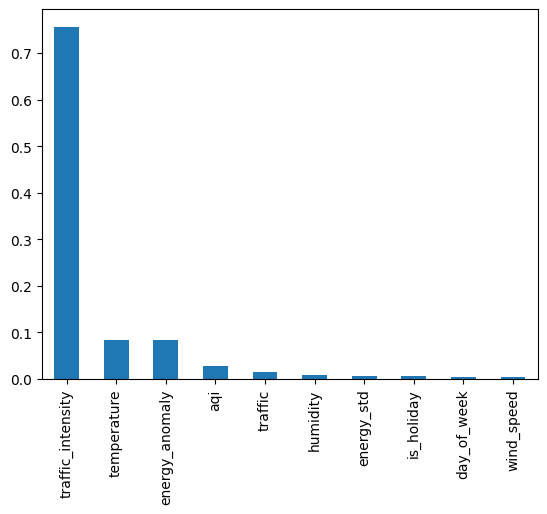

In [1652]:
pd.Series(xgb_reg_model.feature_importances_, index = xgb_reg_model.feature_names_in_).sort_values(ascending = False)[:10].plot(kind = 'bar')
plt.show()

- 교차검증 결과 test score의 평균은 약 0.79로, 모델의 안정성이 확보된 것으로 판단된다.

In [1654]:
cv = cross_validate(estimator=xgb_reg_model, X = X_train, y = y_train)

In [1656]:
cv.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

In [1658]:
cv['test_score'].mean()

0.7909240995517359

- 분위수 회귀모형 적합
  - 기존 회귀모형이 조건부 평균을 예측하여 이상치에 민감하고 예측 구간을 제시하지 못하는 점에 대한 대안으로 분위수 회귀모형을 사용할 수 있다.
  - 독립변수 값에 대한 회귀모형의 분위수 예측값을 도출할 수 있으며 이를 통해 예측의 변동성을 고려할 수 있다.

In [1006]:
import statsmodels.formula.api as smf

In [1661]:
target = pd.concat([X_train, y_train], axis = 1)

In [1663]:
formula = f'energy_consumption ~ {'+'.join(X_train.columns)}'

In [1688]:
quant_pred = []

for q in np.arange(0.2, 1, 0.2):
    quant_model = smf.quantreg(formula = formula, data = target).fit(q)
    quant_pred.append(quant_model.predict(X_test))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [1700]:
quant_pred_df = pd.DataFrame(quant_pred).T
quant_pred_df.columns = [f'q{x}' for x in range(2, 10, 2)]

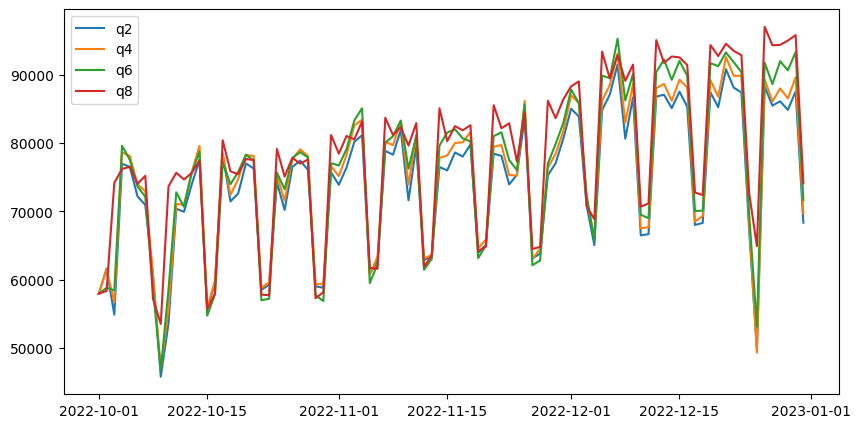

In [1710]:
plt.figure(figsize = (10, 5))
plt.plot(quant_pred_df)
plt.legend([f'q{x}' for x in range(2, 10, 2)])
plt.show()

### 4. 인사이트 및 권장 사항 (20점)

4.1 도시 환경 개선을 위한 권장 사항

위의 분석을 바탕으로, 도시 환경을 개선하기 위한 5가지 실행 가능한 권장 사항을 제시하세요. 각 권장 사항에 대해 데이터 기반 근거를 제공하세요.

- 공기 질은 교통의 집중도에 가장 많은 영향을 받으므로 공기 질 개선을 위해 교통집중도를 완화하는 전략을 수립한다.
- 공기 질은 봄과 여름에 높아지는 경향이 있으므로 봄, 여름철 대중교통을 장려하는 캠페인을 집중한다.
- 교통량은 주말이 아닌 주중에 집중되므로 주중 대중교통을 증편한다.
- 공휴일이 아닌 평일에 대기 질이 악화되는 경향이 있으므로 평일 공기 질 개선 활동 강화한다.
- 기온이 높거나 습도가 낮을 때 공기 질이 악화되므로 기상 상황에 유의한다.

4.2 분석의 한계점 및 개선 방안

이 분석의 한계점과 향후 개선을 위한 추가 데이터 수집 방안을 논의하세요.

- 시간별 데이터로, 시시각각 변하는 공기 질을 실시간 추적예측하기 어렵다.
- 향후 분 단위, 초 단위 데이터를 추가로 수집하여 실시간 대응 및 필요 시 경보 발령에 사용 가능하겠다.

### 5. 데이터 전처리 및 탐색적 데이터 분석 (EDA) (30점)

5-1. 데이터의 품질을 검사하고, 발견된 문제점들을 나열하세요. 각 문제에 대한 적절한 처리 방법을 제안하고 실행하세요.

- date변수가 날짜형식이 아닌 문자형으로 지정되어있음 -> 날짜를 고려한 분석을 위해 datetime 형식으로 변환
- 문자형 변수가 존재하며, 정량적 분석을 위해 인코딩이 필요

In [2621]:
df = pd.read_csv('globalmart_data.csv')

In [2623]:
df['date'] = pd.to_datetime(df['date'])

In [2625]:
df.set_index('date', inplace = True)

In [2627]:
df = df.sort_index()

In [2629]:
df.head()

,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price
date,,,,,,,,,,,,,,
2018-01-01,S0033,Medium,Suburban,C000369,P0029,5,Clothing,419.666502,1.003443,1.0,True,0.187564,340.952318,1710.63
2018-01-01,S0009,Large,Rural,C000701,P0013,2,Food & Beverage,202.418099,1.003443,0.8,True,0.187564,164.451820,264.03
2018-01-01,S0034,Medium,Urban,C000371,P0037,3,Electronics,491.173330,1.003443,1.2,False,0.000000,491.173330,1774.31
2018-01-01,S0038,Large,Urban,C000765,P0050,3,Clothing,444.446199,1.003443,1.2,True,0.144013,380.439980,1374.30
2018-01-01,S0020,Medium,Urban,C000407,P0055,1,Food & Beverage,292.439878,1.003443,1.2,False,0.000000,292.439878,352.14


In [2631]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2018-01-01 to 2022-12-31
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   store_id          100000 non-null  object 
 1   store_size        100000 non-null  object 
 2   store_location    100000 non-null  object 
 3   customer_id       100000 non-null  object 
 4   product_id        100000 non-null  object 
 5   quantity          100000 non-null  int64  
 6   product_category  100000 non-null  object 
 7   base_price        100000 non-null  float64
 8   season_factor     100000 non-null  float64
 9   location_factor   100000 non-null  float64
 10  promotion         100000 non-null  bool   
 11  discount          100000 non-null  float64
 12  price             100000 non-null  float64
 13  total_price       100000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(6)
memory usage: 10.8+ MB


In [2633]:
df.describe(include = 'all')

,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price
count,100000,100000,100000,100000,100000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000,100000.000000,100000.000000,100000.000000
unique,50,3,3,1000,100,NaN,5,NaN,NaN,NaN,2,NaN,NaN,NaN
top,S0021,Large,Suburban,C000615,P0080,NaN,Electronics,NaN,NaN,NaN,False,NaN,NaN,NaN
freq,2086,39836,42032,132,1071,NaN,25988,NaN,NaN,NaN,80082,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,3.007750,NaN,286.586231,1.000421,1.026912,NaN,0.046599,273.215576,844.944985
std,NaN,NaN,NaN,NaN,NaN,1.414238,NaN,134.148982,0.141178,0.149877,NaN,0.107637,132.312411,637.283990
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,13.947305,0.800002,0.800000,NaN,0.000000,7.412887,6.620000
25%,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,178.288812,0.860108,1.000000,NaN,0.000000,166.349658,347.460000
50%,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,278.682079,1.001721,1.000000,NaN,0.000000,268.267618,676.780000
75%,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,405.703018,1.141117,1.200000,NaN,0.000000,382.299245,1198.465000


5-2. 다음 파생변수들을 생성하세요:

a) 고객 생애 가치 (Customer Lifetime Value, CLV)

컬럼명: 'customer_lifetime_value'

각 고객의 총 구매액을 계산

고객의 첫 구매일부터 마지막 구매일까지의 기간(년)을 계산

CLV = 총 구매액 / 고객 생애 기간(년)

만약 고객의 구매가 1년 미만이라면, 1년으로 간주

b) 제품별 수익률

컬럼명: 'product_profit_margin'

제품별 평균 판매가격 계산

제품의 기본 가격(base_price)과 평균 판매가격의 차이를 계산

수익률 = (평균 판매가격 - 기본 가격) / 기본 가격 * 100

c) 매장별 일일 평균 고객 수

컬럼명: 'store_daily_avg_customers'

각 매장, 각 날짜별 유니크 고객 수 계산

매장별로 일일 평균 고객 수 계산

d) 계절성 지표 (월별, 요일별)

컬럼명: 'month_seasonality', 'day_of_week_seasonality'

월별, 요일별 평균 판매액 계산

전체 평균 판매액 대비 각 월, 요일의 상대적인 판매액 비율 계산

In [2636]:
df.groupby('customer_id').total_price.sum()

customer_id
C000001     79640.52
C000002     84918.07
C000003    101434.96
C000004     74382.46
C000005     79884.08
             ...    
C000996     75947.03
C000997     74818.96
C000998    104119.63
C000999     58956.58
C001000     72058.49
Name: total_price, Length: 1000, dtype: float64

In [2638]:
df.head()

,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price
date,,,,,,,,,,,,,,
2018-01-01,S0033,Medium,Suburban,C000369,P0029,5,Clothing,419.666502,1.003443,1.0,True,0.187564,340.952318,1710.63
2018-01-01,S0009,Large,Rural,C000701,P0013,2,Food & Beverage,202.418099,1.003443,0.8,True,0.187564,164.451820,264.03
2018-01-01,S0034,Medium,Urban,C000371,P0037,3,Electronics,491.173330,1.003443,1.2,False,0.000000,491.173330,1774.31
2018-01-01,S0038,Large,Urban,C000765,P0050,3,Clothing,444.446199,1.003443,1.2,True,0.144013,380.439980,1374.30
2018-01-01,S0020,Medium,Urban,C000407,P0055,1,Food & Beverage,292.439878,1.003443,1.2,False,0.000000,292.439878,352.14


In [2639]:
first_purchase = df.groupby('customer_id').head(1).reset_index().set_index('customer_id')['date']
last_purchase = df.groupby('customer_id').tail(1).reset_index().set_index('customer_id')['date']
purchase_period = ((last_purchase - first_purchase).dt.days / 365).map(lambda x : 1 if x < 1 else int(x))

In [2642]:
customer_lifetime_value = df.groupby('customer_id').total_price.sum() / purchase_period

In [2644]:
customer_lifetime_value.name = 'customer_lifetime_value'

In [2646]:
df = pd.merge(df, customer_lifetime_value, how = 'left', left_on = 'customer_id', right_index=True)

In [2662]:
base_price_mean = df.groupby('product_id').base_price.mean()

In [2650]:
base_price_mean.name = 'base_price_mean'

In [2652]:
df = pd.merge(df, base_price_mean, how = 'left', left_on = 'product_id', right_index = True)

In [2656]:
df['product_profit_margin'] = (df['base_price_mean'] - df['base_price']) / df['base_price']

In [2672]:
df['store_daily_avg_customers'] = df.groupby(['store_id','date']).customer_id.transform('count')

In [2694]:
df['month_seasonality'] = df.groupby(df.index.month).total_price.transform('mean') / df.total_price.mean()

In [2696]:
df['day_of_week_seasonality'] = df.groupby(df.index.day_of_week).total_price.transform('mean') / df.total_price.mean()

In [2702]:
df.drop(columns = 'base_price_mean', inplace = True)

5-3. 매출에 영향을 미치는 주요 요인들을 시각화하여 분석하세요. 최소 5개의 다른 차트 유형을 사용하여 인사이트를 도출하세요.

- 매출(total_price)에는 quantity, base_price, price가 가장 많은 영향을 미치는 것으로 나타난다. 이는 total_price가 quantity와 price의 선형조합이기 때문인 것으로 판단된다.
- 위 변수를 제외하고 살펴보면 location_factor, seasonal_factor, seasonal_mean하고는 양의 상관관계를 보인다. 다만, 그 정도는 0.2 이내로 약하다.
- price_discount, price_promotion과는 음의 상관관계를 보인다. 다만, 그 정도는 -0.15 이내로 ㅠ약하다.
- 매출에는 가격 할인과 프로모션을 진행하면 매출 감소보다 홍보를 통한 고객 유치효과가 더 클 수 있다는 시사점을 도출할 수 있다.

<Axes: >

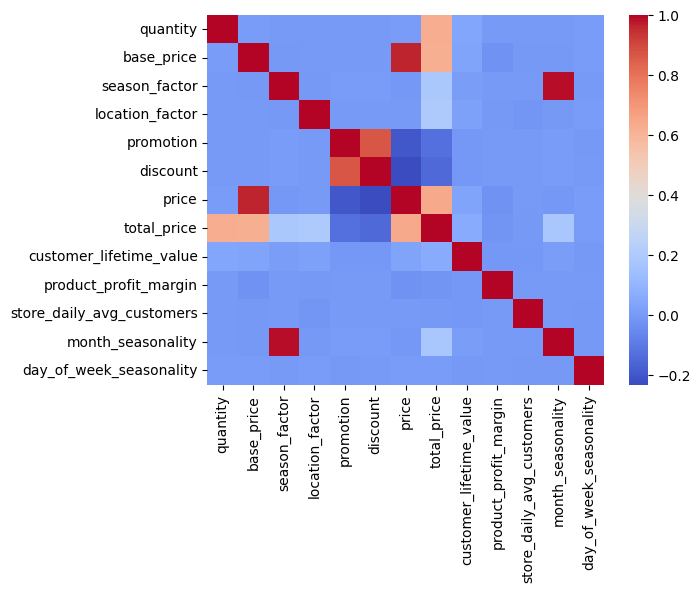

In [2706]:
target = df.select_dtypes(exclude = 'object')
sns.heatmap(target.corr(), cmap = 'coolwarm')

In [2708]:
from itertools import combinations

In [2710]:
col_name = []
corr_lst = []
for col in target.drop(columns = ['total_price','quantity','base_price','price']):
    col_name.append(f'total_price-{col}')
    corr_lst.append(target[['total_price', col]].corr().iloc[0,1])

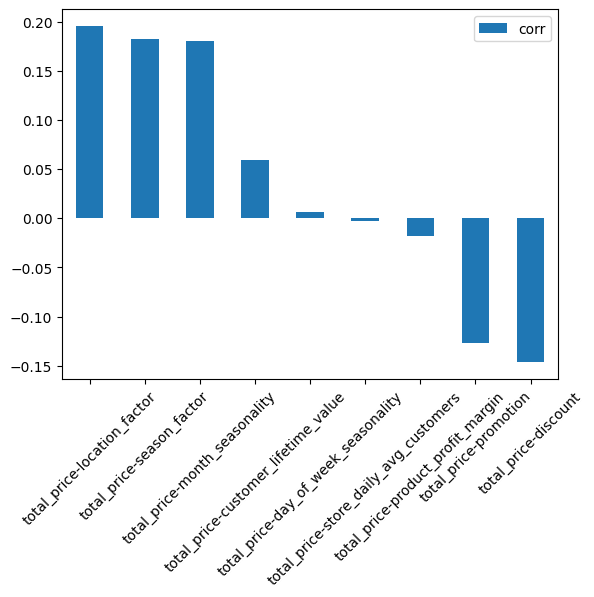

In [2712]:
pd.DataFrame(corr_lst[:5]+corr_lst[5:] , index = col_name[:5] + col_name[5:], columns = ['corr']).sort_values(by = 'corr', ascending = False).plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.show()

5-4. 매장 위치, 크기, 재고 회전율 등의 요소가 매출에 미치는 영향을 분석하세요. 상관관계 분석과 적절한 통계 검정을 수행하세요.

- 다중선형회귀분석을 통해 통계적 유의성을 검정한다.
  - 검정 결과 아래 변수의 p-value가 0.05 미만으로 매출에 통계적으로 유의미한 영향을 미치는 것으로 나타난다.
      - 'discount', 'customer_lifetime_value', 'season_factor',
       'store_location_Rural', 'store_location_Urban',
       'product_category_Sports & Outdoors', 'product_category_Clothing',
       'store_size_Large'

In [2714]:
import statsmodels.api as sm

In [2716]:
df.head()

,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price,customer_lifetime_value,product_profit_margin,store_daily_avg_customers,month_seasonality,day_of_week_seasonality
date,,,,,,,,,,,,,,,,,,,
2018-01-01,S0033,Medium,Suburban,C000369,P0029,5,Clothing,419.666502,1.003443,1.0,True,0.187564,340.952318,1710.63,22248.5250,0.0,3,1.061033,1.004811
2018-01-01,S0009,Large,Rural,C000701,P0013,2,Food & Beverage,202.418099,1.003443,0.8,True,0.187564,164.451820,264.03,25223.6750,0.0,1,1.061033,1.004811
2018-01-01,S0034,Medium,Urban,C000371,P0037,3,Electronics,491.173330,1.003443,1.2,False,0.000000,491.173330,1774.31,22405.6225,0.0,2,1.061033,1.004811
2018-01-01,S0038,Large,Urban,C000765,P0050,3,Clothing,444.446199,1.003443,1.2,True,0.144013,380.439980,1374.30,18099.7875,0.0,3,1.061033,1.004811
2018-01-01,S0020,Medium,Urban,C000407,P0055,1,Food & Beverage,292.439878,1.003443,1.2,False,0.000000,292.439878,352.14,18411.0425,0.0,2,1.061033,1.004811


In [2722]:
df2 = df.drop(columns = ['store_id','customer_id','product_id','quantity','base_price','price'])

In [2724]:
target = pd.get_dummies(df2 * 1, dtype=int)

In [2726]:
X = target.drop(columns = ['total_price'])
Y = target[['total_price']]

In [2728]:
X = sm.add_constant(X)

In [2730]:
ols_model = sm.OLS(endog=Y, exog=X).fit()

In [2732]:
ols_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     735.5
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:14:44   Log-Likelihood:            -7.8238e+05
No. Observations:              100000   AIC:                         1.565e+06
Df Residuals:                   99984   BIC:                         1.565e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               -374.4345    140.881     -2.658      0.008    -650.559     -98.309
season_factor                        724.9031     83.052      8.728      0.000     562.122     887.684
location_factor                     -285.4610    130.452     -2.188      0.029    -541.145     -29.777
promotion                             -1.2263      9.648     -0.127      0.899     -20.136      17.684
discount                            -863.0146     35.799    -24.107      0.000    -933.180    -792.849
customer_lifetime_value                0.0123      0.001     17.474      0.000       0.011       0.014
product_profit_margin              -6.057e-12   2.75e-12     -2.201      0.028   -1.14e-11   -6.64e-13
store_daily_avg_customers             -0.3301      1.815     -0.182      0.856      -3.887       3.227
month_seasonality                    107.3882     85.987      1.249      0.212     -61.146     275.922
day_of_week_seasonality              748.3330    392.812      1.905      0.057     -21.573    1518.239
store_size_Large                    -129.2693     47.027     -2.749      0.006    -221.441     -37.098
store_size_Medium                   -119.9318     47.046     -2.549      0.011    -212.142     -27.722
store_size_Small                    -125.2333     47.061     -2.661      0.008    -217.473     -32.994
store_location_Rural                -345.7154     73.095     -4.730      0.000    -488.981    -202.450
store_location_Suburban             -127.8711     47.057     -2.717      0.007    -220.102     -35.641
store_location_Urban                  99.1521     21.031      4.714      0.000      57.931     140.373
product_category_Clothing           -105.2655     28.522     -3.691      0.000    -161.169     -49.362
product_category_Electronics         -49.2343     28.398     -1.734      0.083    -104.894       6.425
product_category_Food & Beverage     -23.8716     28.423     -0.840      0.401     -79.581      31.838
product_category_Home & Garden       -73.4772     28.408     -2.587      0.010    -129.156     -17.798
product_category_Sports & Outdoors  -122.5858     28.489     -4.303      0.000    -178.423     -66.748
==============================================================================
Omnibus:                     9726.972   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12797.096
Skew:                           0.855   Prob(JB):                         0.00
Kurtosis:                       3.388   Cond. No.                     3.71e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-

In [2734]:
ols_model.pvalues.sort_values(ascending = True)

discount                              4.872182e-128
customer_lifetime_value                2.838235e-68
season_factor                          2.623781e-18
store_location_Rural                   2.252003e-06
store_location_Urban                   2.426354e-06
product_category_Sports & Outdoors     1.686880e-05
product_category_Clothing              2.237989e-04
store_size_Large                       5.981494e-03
store_location_Suburban                6.581113e-03
store_size_Small                       7.790487e-03
const                                  7.866338e-03
product_category_Home & Garden         9.696709e-03
store_size_Medium                      1.079754e-02
product_profit_margin                  2.770509e-02
location_factor                        2.865369e-02
day_of_week_seasonality                5.677400e-02
product_category_Electronics           8.296816e-02
month_seasonality                      2.117098e-01
product_category_Food & Beverage       4.009876e-01
store_daily_

In [2736]:
(ols_model.pvalues.sort_values(ascending = True) < 0.05)[:'store_size_Large'].index

Index(['discount', 'customer_lifetime_value', 'season_factor',
       'store_location_Rural', 'store_location_Urban',
       'product_category_Sports & Outdoors', 'product_category_Clothing',
       'store_size_Large'],
      dtype='object')

### 6. 예측 모델링 (40점)

6-1. 일일 매출 예측 모델을 개발하세요. 다음 세 가지 접근 방식을 비교하세요:

a) 시계열 모델 (예: ARIMA, Prophet)

b) 머신러닝 모델 (예: Random Forest, XGBoost)

c) 딥러닝 모델 (예: LSTM)

각 모델의 성능을 평가하고, 예측 정확도뿐만 아니라 해석 가능성과 실용성 측면에서도 비교하세요.

- 매출은 일별 총 매출, 그 외 변수는 일별 평균으로 집계한다.
- 학습, 시험데이터 분리
  - 시계열 데이터이므로 2022년의 데이터를 시험데이터로 분리한다.

In [2739]:
y = target.groupby(target.index.date).total_price.sum()
X = target.drop(columns = 'total_price').groupby(target.index.date).mean()

In [2741]:
X.index = pd.to_datetime(X.index)
y.index = pd.to_datetime(y.index)

In [2743]:
y.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=1826, freq=None)

In [2745]:
X_train = X.loc[X.index.year != 2022,:]
X_test = X.loc[X.index.year == 2022,:]
y_train = y.loc[y.index.year != 2022]
y_test = y.loc[y.index.year == 2022]

- ARIMA 모델 적합

- AR항 p = 0, 차분 d = 1, MA항 q = 1의 ARIMA모델이 적합되었다.

In [2749]:
arima_model = auto_arima(y_train)

In [2750]:
arima_model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

- XGBoost 모델 적합

In [2754]:
xgb_model = XGBRegressor()

In [2756]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- 딥러닝 모델(LSTM)

In [1247]:
# ! pip install keras

In [1251]:
# ! pip install tensorflow

In [2784]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2790]:
model = Sequential()
model.add(LSTM(units = activation='relu'))
model.add(Dense(units=1))

TypeError: LSTM.__init__() missing 1 required positional argument: 'units'

In [2792]:
? LSTM

Init signature:
 LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    use_cudnn='auto',
    **kwargs,
)
Docstring:     
Long Short-Term Memory layer - Hochreiter 1997.

Based on available runtime hardware and constraints, this layer
will choose different implementations (cuDNN-based or backend-native)
to maximize the performance. If a GPU is available and all
the arguments to the layer meet the requirement of the cuDNN kernel
(see belo

In [2788]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [2778]:
y_train.shape

(1461,)

In [2776]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=70, batch_size=30)
pred_y = model.predict(X_test)

Epoch 1/70


ValueError: Input 0 of layer "lstm_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 20)

- 모델 성능 비교

- 시험데이터로 mse계산 결과 xgb모델의 mse가 낮아 성능이 우수한 것으로 나타난다.

In [2795]:
arima_pred = arima_model.predict(n_periods = len(X_test))

In [2797]:
xgb_pred = xgb_model.predict(X_test)

In [2799]:
arima_mse = mean_squared_error(y_test, arima_pred)

In [2801]:
xgb_mse = mean_squared_error(y_test, xgb_pred)

In [2803]:
arima_mse > xgb_mse

True

### 6-2. 고객 세그먼테이션을 위한 클러스터링 모델을 개발하세요. 다음 단계를 따르세요:

a) 적절한 특성을 선택하고 전처리하세요.

b) 최적의 클러스터 수를 결정하기 위한 방법을 적용하세요.

c) 선택한 클러스터링 알고리즘을 적용하고 결과를 시각화하세요.

d) 각 클러스터의 특성을 해석하고, 비즈니스적 의미를 설명하세요.

- 고객 세그먼트 군집을 위해 Kmeans Clustering을 수행한다.
- 특성의 수가 매우 많으므로 모델 효율화를 위해 주성분분석을 이용해 차원 축소를 진행한다.
- 변수별 단위 차이에 따른 왜곡 방지를 위해 스케일링을 선행한다.

In [2806]:
sc = StandardScaler()

In [2808]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2810]:
sc_df = pd.DataFrame(sc.fit_transform(target), columns = target.columns)

In [2812]:
sc_df

,season_factor,location_factor,promotion,discount,total_price,customer_lifetime_value,product_profit_margin,store_daily_avg_customers,month_seasonality,day_of_week_seasonality,...,store_size_Medium,store_size_Small,store_location_Rural,store_location_Suburban,store_location_Urban,product_category_Clothing,product_category_Electronics,product_category_Food & Beverage,product_category_Home & Garden,product_category_Sports & Outdoors
0,0.021405,-0.179561,2.005139,1.309637,1.358404,0.336991,-0.055916,0.855255,0.447595,0.988021,...,1.528981,-0.657835,-0.535045,1.174368,-0.745319,2.458604,-0.592564,-0.512502,-0.546659,-0.436549
1,0.021405,-1.513994,2.005139,1.309637,-0.911553,1.432008,-0.055916,-1.042065,0.447595,0.988021,...,-0.654030,-0.657835,1.869003,-0.851522,-0.745319,-0.406735,-0.592564,1.951212,-0.546659,-0.436549
2,0.021405,1.154871,-0.498718,-0.432936,1.458329,0.394812,-0.055916,-0.093405,0.447595,0.988021,...,1.528981,-0.657835,-0.535045,-0.851522,1.341708,-0.406735,1.687581,-0.512502,-0.546659,-0.436549
3,0.021405,1.154871,2.005139,0.905031,0.830646,-1.189969,-0.055916,0.855255,0.447595,0.988021,...,-0.654030,-0.657835,-0.535045,-0.851522,1.341708,2.458604,-0.592564,-0.512502,-0.546659,-0.436549
4,0.021405,1.154871,-0.498718,-0.432936,-0.773293,-1.075411,-0.055916,-0.093405,0.447595,0.988021,...,1.528981,-0.657835,-0.535045,-0.851522,1.341708,-0.406735,-0.592564,1.951212,-0.546659,-0.436549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.002980,-1.513994,-0.498718,-0.432936,0.347924,-0.056391,-0.055916,0.855255,-0.338329,1.064478,...,1.528981,-0.657835,1.869003,-0.851522,-0.745319,2.458604,-0.592564,-0.512502,-0.546659,-0.436549
99996,-0.002980,-1.513994,-0.498718,-0.432936,-1.088257,-2.064775,-0.055916,-1.042065,-0.338329,1.064478,...,-0.654030,-0.657835,1.869003,-0.851522,-0.745319,-0.406735,-0.592564,1.951212,-0.546659,-0.436549
99997,-0.002980,1.154871,-0.498718,-0.432936,-0.517817,-0.264663,-0.055916,-1.042065,-0.338329,1.064478,...,-0.654030,-0.657835,-0.535045,-0.851522,1.341708,-0.406735,-0.592564,1.951212,-0.546659,-0.436549
99998,-0.002980,1.154871,2.005139,0.325985,-0.036569,-0.402017,-0.055916,-1.042065,-0.338329,1.064478,...,-0.654030,-0.657835,-0.535045,-0.851522,1.341708,-0.406735,1.687581,-0.512502,-0.546659,-0.436549


In [2814]:
pca = PCA()

In [2816]:
pca.fit(sc_df)

PCA()

- PCA의 갯수 n = 9일 때 분산 변동분의 80% 이상이 설명된다.
- 따라서 n = 9로 변수를 축약한다.

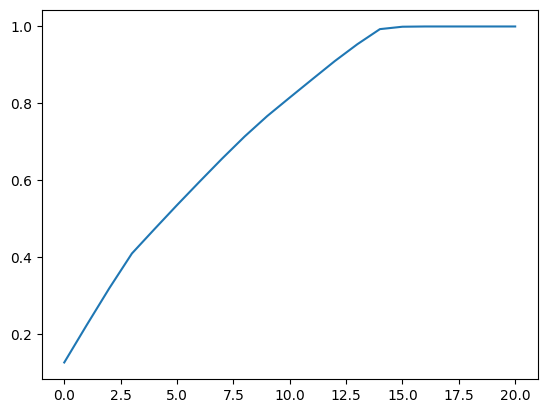

In [2819]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

In [2821]:
pca.explained_variance_ratio_.cumsum()

array([0.12535535, 0.2231738 , 0.31883345, 0.40906543, 0.47246728,
       0.53494974, 0.59595872, 0.65599694, 0.71360971, 0.76671363,
       0.81491291, 0.86260817, 0.90994899, 0.95382429, 0.99309293,
       0.99936225, 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [2823]:
pca = PCA(n_components=9)

In [3186]:
pc_df = pd.DataFrame(pca.fit_transform(sc_df), columns = [f'PC{x}' for x in range(1, 10)])

In [2854]:
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.051154,0.634315,-1.777393,2.201685,-0.079253,-1.666539,-0.542172,1.587095,-0.871280
1,-2.045671,-0.676403,2.170706,2.215129,-0.374049,-0.818469,-1.541510,-1.492500,-0.748133
2,2.534954,0.638587,-0.384738,-0.594001,1.939101,-0.052398,0.432127,-0.158183,-0.378271
3,1.942257,-0.594939,1.417469,2.067894,-0.365950,-0.151613,-0.712319,2.023920,-0.647397
4,2.045874,0.118876,-0.461243,-0.339894,-0.478860,-0.673152,-1.522227,-1.111212,-0.542936


In [2856]:
PCA_comp_df.sort_values(by = ['PC1','PC2','PC3','PC4'], ascending = False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
location_factor,0.589556,-0.083670,0.056397,-0.038910,0.164062,-0.014601,0.063134,0.010374,-0.026574
store_location_Urban,0.548849,0.212214,0.037072,-0.036477,0.183148,-0.011109,0.071296,0.042373,-0.179010
total_price,0.190562,-0.044518,-0.185155,0.007217,0.170269,0.066716,-0.208342,-0.063861,0.414920
store_size_Medium,0.176581,-0.383927,0.040593,0.098499,-0.532394,0.010490,-0.081367,0.031699,-0.210090
store_size_Large,0.068559,0.553694,-0.024013,0.019715,-0.175569,0.000959,-0.063987,-0.076369,0.313514
season_factor,0.016659,-0.009742,-0.030609,-0.004425,0.099475,0.048544,-0.183461,-0.099022,0.621707
product_category_Electronics,0.006062,0.000035,-0.001560,0.808900,0.163707,-0.195012,-0.169316,-0.046020,-0.063035
product_category_Food & Beverage,0.002576,-0.005219,-0.021238,-0.211103,0.035677,0.741481,-0.385334,-0.061972,-0.175215
daily_customer,-0.000269,0.005095,-0.002029,0.022731,0.005609,-0.001112,0.021251,-0.030837,0.109765
product_category_Sports & Outdoors,-0.000594,0.001587,0.014698,-0.086479,-0.105747,0.075987,0.678933,-0.562555,0.095998


- 최적의 군집 수를 구하기 위해서 9개의 주성분을 기준으로 Kmeans Clustering을 수행한다.
- Kmeans Clustering은 사전에 지정한 군집의 수를 기준으로, 임의의 중심에서 가까운 데이터를 같은 군집으로 분류하고 군집 중심을 수정해가면서 최종 군집을 완성해가는 알고리즘이다.
- 최적 군집 수를 찾기 위해 군집 내 분산이 크게 감소하는 지점을 찾는다.
- 군집 내 분산은 군집 수가 6개일 때까지 크게 감소하다가 그 이후 군집 수부터는 점차적으로 감소하는 모습을 보이므로 최적 군집 수를 6개로 결정한다.

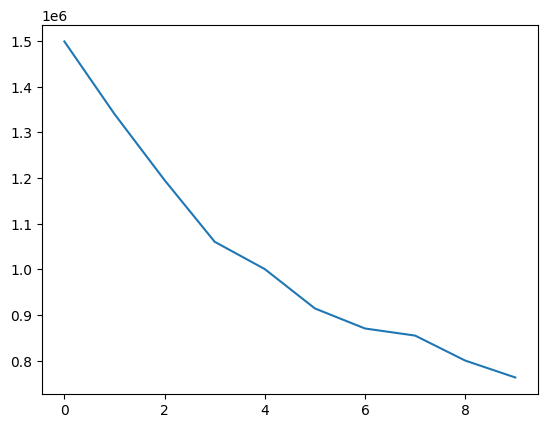

In [3188]:
sse = []

for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(pc_df)
    sse.append(km.inertia_)
plt.plot(sse)
plt.show()

In [3213]:
k = 4

km = KMeans(n_clusters=k, random_state = 42)
km.fit(pc_df)

KMeans(n_clusters=4, random_state=42)

In [3225]:
target['label'] = km.labels_

In [3217]:
pc_df.label.value_counts()

label
1    34427
2    30429
0    19662
3    15482
Name: count, dtype: int64

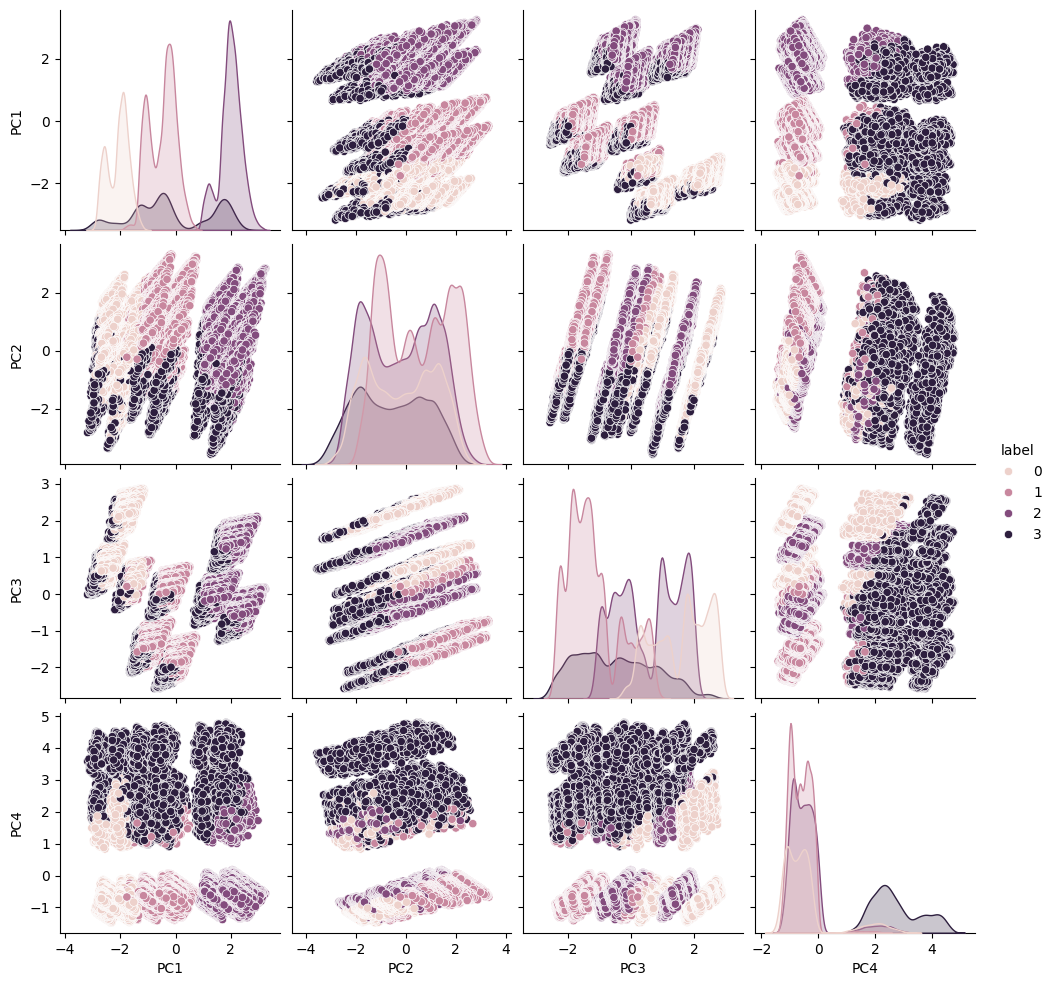

In [3219]:
sns.pairplot(data = pc_df[['PC1','PC2','PC3','PC4','label']], hue = 'label')
plt.show()

- 군집별 특성
  - 군집 1(label = 0)은 지방에 위치한 대형마트를 찾는 고객이다.
  - 군집 2(lable = 1)은 프로모션과 할인에 민감하지 않고 suburban지역의 마트를 찾는 고객이다.
  - 군집 3(label = 2)은 총 구매액이 많음면서 도시 지역의 매장을 찾는 고객이다.
  - 군집 4(label = 3)은 프로모션과 할인에 민감하나 총 구매액은 많지 않는 고객이다.

In [3249]:
pd.options.display.float_format = '{:.4f}'.format

In [3251]:
target.groupby('label').mean().T

label,0,1,2,3
season_factor,1.0005,1.0007,1.0025,0.9956
location_factor,0.8000,0.9972,1.2000,1.0410
promotion,0.1168,0.0091,0.0600,1.0000
discount,0.0191,0.0009,0.0083,0.2583
total_price,673.0457,863.5211,1051.3193,616.3312
customer_lifetime_value,21273.5313,21335.3560,21415.5642,21240.5102
product_profit_margin,0.0000,0.0000,0.0000,0.0000
store_daily_avg_customers,2.1222,2.0890,2.0913,2.1034
month_seasonality,1.0003,1.0001,1.0020,0.9955
day_of_week_seasonality,0.9999,1.0001,1.0000,1.0000


In [3223]:
pc_df.groupby('label').mean()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
label,,,,,,,,,
0,-2.085406,-0.182788,1.578496,-0.443615,0.009495,-0.239615,0.001149,-0.039433,-0.044711
1,-0.489895,0.535564,-1.169452,-0.620495,0.052970,-0.191903,0.054815,-0.063675,0.022773
2,1.979080,-0.191496,0.554715,-0.407253,-0.058140,0.322299,-0.044008,0.115832,0.027445
3,-0.151954,-0.582408,-0.494452,2.743601,-0.015576,0.097580,-0.036855,-0.035990,-0.047799


- 비즈니스적 시사점

- 군집 1, 2, 3는 가격과 판촉행사에 크게 민감하게 반응하지 않았으며 군집 4만 민감하게 반응하는 경향을 보였다.

  따라서 가격 할인 행사를 할 때 군집 4 고객에게 홍보를 강화하는 방안을 고려해볼 수 있다.
  한편 군집 2는 할인 행사와 관계 없이 구매액이 많은 고객으로 충성도 강화를 위해 각종 멤버십 혜택을 제공하는 것이 적절해보인다.
  
- 군집 1의 경우 위치요소의 영향을 많이 받지 않으나 군집 2의 경우 위치요소의 영향을 많이 받는다.

  군집 2 고객이 많이 거주하는 지역에 마트를 설립하거나 배송 서비스를 시작하는 것으로 고려해 볼 수 있다.

### 6-3. 장바구니 분석을 수행하여 제품 간의 연관 규칙을 찾으세요. 다음을 포함하세요:

a) 지지도, 신뢰도, 향상도의 개념을 설명하고, 임계값을 설정하세요.

b) 가장 강력한 연관 규칙 상위 10개를 제시하고 해석하세요.

c) 발견된 규칙을 바탕으로 교차 판매 및 상향 판매 전략을 제안하세요.

- 지지도: 전체 거래 중 상품이 동시에 포함된 거래의 비중
- 신뢰도: 한 상품을 구매했을 때 연관되는 상품도 구매할 확률, 조건부확률로 표현할 수 있다.
- 향상도: 상품을 구매할 전체 확률과 다른 상품을 구매했을 때 이를 구매할 조건부확률의 비율

- 임계값은 강한 연관 규칙을 찾기 위해 10%로 설정하고 추후 보완하도록 한다. (apriori)

In [3255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2018-01-01 to 2022-12-31
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   store_id                   100000 non-null  object 
 1   store_size                 100000 non-null  object 
 2   store_location             100000 non-null  object 
 3   customer_id                100000 non-null  object 
 4   product_id                 100000 non-null  object 
 5   quantity                   100000 non-null  int64  
 6   product_category           100000 non-null  object 
 7   base_price                 100000 non-null  float64
 8   season_factor              100000 non-null  float64
 9   location_factor            100000 non-null  float64
 10  promotion                  100000 non-null  bool   
 11  discount                   100000 non-null  float64
 12  price                      100000 non-null  float64
 13  total_price  

In [3257]:
df.head()

,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price,customer_lifetime_value,product_profit_margin,store_daily_avg_customers,month_seasonality,day_of_week_seasonality
date,,,,,,,,,,,,,,,,,,,
2018-01-01,S0033,Medium,Suburban,C000369,P0029,5,Clothing,419.6665,1.0034,1.0000,True,0.1876,340.9523,1710.6300,22248.5250,0.0000,3,1.0610,1.0048
2018-01-01,S0009,Large,Rural,C000701,P0013,2,Food & Beverage,202.4181,1.0034,0.8000,True,0.1876,164.4518,264.0300,25223.6750,0.0000,1,1.0610,1.0048
2018-01-01,S0034,Medium,Urban,C000371,P0037,3,Electronics,491.1733,1.0034,1.2000,False,0.0000,491.1733,1774.3100,22405.6225,0.0000,2,1.0610,1.0048
2018-01-01,S0038,Large,Urban,C000765,P0050,3,Clothing,444.4462,1.0034,1.2000,True,0.1440,380.4400,1374.3000,18099.7875,0.0000,3,1.0610,1.0048
2018-01-01,S0020,Medium,Urban,C000407,P0055,1,Food & Beverage,292.4399,1.0034,1.2000,False,0.0000,292.4399,352.1400,18411.0425,0.0000,2,1.0610,1.0048


In [3259]:
pd.get_dummies(df, columns = ['product_category'])

,store_id,store_size,store_location,customer_id,product_id,quantity,base_price,season_factor,location_factor,promotion,...,customer_lifetime_value,product_profit_margin,store_daily_avg_customers,month_seasonality,day_of_week_seasonality,product_category_Clothing,product_category_Electronics,product_category_Food & Beverage,product_category_Home & Garden,product_category_Sports & Outdoors
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,S0033,Medium,Suburban,C000369,P0029,5,419.6665,1.0034,1.0000,True,...,22248.5250,0.0000,3,1.0610,1.0048,True,False,False,False,False
2018-01-01,S0009,Large,Rural,C000701,P0013,2,202.4181,1.0034,0.8000,True,...,25223.6750,0.0000,1,1.0610,1.0048,False,False,True,False,False
2018-01-01,S0034,Medium,Urban,C000371,P0037,3,491.1733,1.0034,1.2000,False,...,22405.6225,0.0000,2,1.0610,1.0048,False,True,False,False,False
2018-01-01,S0038,Large,Urban,C000765,P0050,3,444.4462,1.0034,1.2000,True,...,18099.7875,0.0000,3,1.0610,1.0048,True,False,False,False,False
2018-01-01,S0020,Medium,Urban,C000407,P0055,1,292.4399,1.0034,1.2000,False,...,18411.0425,0.0000,2,1.0610,1.0048,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,S0031,Medium,Rural,C000316,P0050,3,444.4462,1.0000,0.8000,False,...,21179.7100,0.0000,3,0.9539,1.0052,True,False,False,False,False
2022-12-31,S0010,Large,Rural,C000110,P0056,1,189.2800,1.0000,0.8000,False,...,15722.9500,0.0000,1,0.9539,1.0052,False,False,True,False,False
2022-12-31,S0046,Large,Urban,C000743,P0045,3,143.0413,1.0000,1.2000,False,...,20613.8350,0.0000,1,0.9539,1.0052,False,False,True,False,False


In [3261]:
from mlxtend.frequent_patterns import apriori, association_rules

In [3304]:
relation_df = df.groupby(['date','customer_id','product_category']).size().unstack().fillna(0).reset_index(drop = True)
relation_df = relation_df.map(lambda x : 0 if x == 0 else 1)
relation_df = relation_df.loc[relation_df.sum(axis = 1) >= 2]

In [2223]:
# ! pip install mlxtend

- 연관규칙을 살펴보면 전자제품을 구매하는 고객은 가정용품과 원예용품을 함께 구매하는 경향이 가장 강한 것으로 나타났으며
- 식음료를 구매하는 고객 또한 전자제품을 함께 구매하는 경향이 강한 것으로 나타난다.

In [3320]:
ap_df = apriori(df = relation_df, min_support = 0.1, use_colnames = True).sort_values(by = 'support', ascending = False).reset_index(drop = True)
ap_df

,support,itemsets
0,0.5065,(Electronics)
1,0.4464,(Home & Garden)
2,0.4016,(Food & Beverage)
3,0.3302,(Clothing)
4,0.3242,(Sports & Outdoors)
5,0.1535,"(Electronics, Home & Garden)"
6,0.1343,"(Electronics, Food & Beverage)"
7,0.1143,"(Electronics, Clothing)"
8,0.1143,"(Food & Beverage, Home & Garden)"
9,0.1115,"(Electronics, Sports & Outdoors)"


In [3322]:
association_rules(df = ap_df, metric = 'confidence', min_threshold= 0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Electronics),(Home & Garden),0.5065,0.4464,0.1535,0.3029,0.6787,-0.0726,0.7943,-0.4896
1,(Home & Garden),(Electronics),0.4464,0.5065,0.1535,0.3438,0.6787,-0.0726,0.7520,-0.4609
2,(Electronics),(Food & Beverage),0.5065,0.4016,0.1343,0.2652,0.6604,-0.0691,0.8144,-0.5103
3,(Food & Beverage),(Electronics),0.4016,0.5065,0.1343,0.3345,0.6604,-0.0691,0.7415,-0.4622
4,(Electronics),(Clothing),0.5065,0.3302,0.1143,0.2256,0.6832,-0.0530,0.8649,-0.4845
5,(Clothing),(Electronics),0.3302,0.5065,0.1143,0.3460,0.6832,-0.0530,0.7546,-0.4091
6,(Food & Beverage),(Home & Garden),0.4016,0.4464,0.1143,0.2846,0.6375,-0.0650,0.7738,-0.4872
7,(Home & Garden),(Food & Beverage),0.4464,0.4016,0.1143,0.2560,0.6375,-0.0650,0.8043,-0.5067
8,(Electronics),(Sports & Outdoors),0.5065,0.3242,0.1115,0.2201,0.6789,-0.0527,0.8665,-0.4894
9,(Sports & Outdoors),(Electronics),0.3242,0.5065,0.1115,0.3439,0.6789,-0.0527,0.7521,-0.4117


- 교차 판매 및 상향 판매 전략
  - 전자제품과 가정용품 및 원예용품을 같은 층에 배치한다.
  - 전자제품 구매 후 계산대에 식음료를 배치한다.

### 7. 최적화 및 의사결정 (20점)

7-1. 매장별 재고 최적화 모델을 개발하세요. 다음 요소를 고려하세요:

a) 과거 판매 데이터

b) 제품의 유통기한

c) 보관 비용

d) 품절로 인한 기회 비용

모델의 목적 함수와 제약 조건을 명확히 정의하고, 솔루션 접근 방식을 설명하세요.

In [2461]:
df.head()

,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price,daily_customer,daily_seasonal_mean,monthly_seasonal_mean
date,,,,,,,,,,,,,,,,,
2018-01-01,S0033,Medium,Suburban,C000369,P0029,5,Clothing,419.666502,1.003443,1.0,True,0.187564,340.952318,1710.63,62,1.003443,1.053602
2018-01-01,S0009,Large,Rural,C000701,P0013,2,Food & Beverage,202.418099,1.003443,0.8,True,0.187564,164.451820,264.03,62,1.003443,1.053602
2018-01-01,S0034,Medium,Urban,C000371,P0037,3,Electronics,491.173330,1.003443,1.2,False,0.000000,491.173330,1774.31,62,1.003443,1.053602
2018-01-01,S0038,Large,Urban,C000765,P0050,3,Clothing,444.446199,1.003443,1.2,True,0.144013,380.439980,1374.30,62,1.003443,1.053602
2018-01-01,S0020,Medium,Urban,C000407,P0055,1,Food & Beverage,292.439878,1.003443,1.2,False,0.000000,292.439878,352.14,62,1.003443,1.053602


7-2. A/B 테스트를 설계하여 새로운 매장 레이아웃의 효과를 측정하는 계획을 수립하세요. 다음을 포함하세요:

a) 귀무가설과 대립가설 설정

b) 필요한 표본 크기 계산

c) 실험 기간 설정

d) 성공 지표 정의

e) 잠재적인 편향을 최소화하기 위한 전략

- 새로운 매장 레이아웃을 store_size로 정의하고 매장 레이아웃별 총매출 total_price의 차이가 있는지 검정한다.

- 매장 레이아웃 'Small','Medium'을 'Small&Medium'으로 합쳐 'Large'와 두 범주로 축약한다.

- 귀무가설: 매장 레이아웃별 total_price에 차이가 있다. /  대립가설 : 'Large'매장의 total_price가 'Small&Medium' 매장보다 많다.

- 필요한 표본 크기: 오차의 한계와 유의수준에 따라 달라질 것이며, 오차의 한계가 클수록 필요한 표본의 크기는 작아지고 유의수준이 클수록 필요한 표본의 크기는 작아질 것이다.

- 실험 기간 설정: 계절적인 요인에 따른 영향을 최소화하기 위해 연간 단위로 실험 기간을 설정하는 것이 바람직해보인다.

- 성공 지표 정의: A/B테스트를 위해 total_price의 평균으로 성공 지표(?)를 정의한다.

- 잠재적인 편향을 최소화하기 위한 전략: 편향이란 표본추출 과정 또는 추출한 표본의 무작위성으로 발생하는 관측치의 불확실성을 의미한다. 편향을 최소화하기 위해서는 표본 추출 시 조사자의 주관이 개입되지 않도록 순수하게 무작위 추출을 진행하여 표본이 모집단을 대표하도록 주의를 기울여야 할 것이다.

### 8. 비즈니스 통찰 및 제안 (10점)

8-1. 분석 결과를 바탕으로, GlobalMart의 매출을 증대시키고 고객 경험을 개선하기 위한 5가지 핵심 전략을 제안하세요. 각 전략에 대해 다음을 포함하세요:

a) 데이터 기반 근거

b) 예상되는 비즈니스 임팩트

c) 실행을 위한 단계별 계획

d) 잠재적 위험과 그 완화 방안

- 고객 관리 강화 필요(멤버십)
- 구매액이 크면서 위치에 민감한 고객을 감안하여 일정 금액 이상 구매 시 무료배송 서비스 실시
- 가격 할인과 프로모션을 통한 고객 유치
- 구매 연관성이 높은 상품을 같은 공간에 배치(전자제품-의류-식음료)
- 계절적 요인이 매출에 많은 영향을 미치는 것으로 판단되므로 이에 대한 세밀한 대응이 필요

8-2. 이 분석 프로젝트의 한계점을 논의하고, 향후 개선을 위한 추가 데이터 수집 및 분석 방향을 제안하세요.

평가 기준:

데이터 처리 및 분석의 정확성과 철저함

사용된 방법론의 적절성과 다양성

결과의 해석 및 비즈니스 통찰력

제안된 전략의 실현 가능성과 창의성

전반적인 보고서의 구조와 명확성

참고사항:

모든 코드와 분석 과정을 명확히 문서화하세요.

사용한 가정들을 명시하고 정당화하세요.

결과를 비즈니스 관점에서 해석하는 것에 중점을 두세요.

시각화와 요약 통계를 효과적으로 활용하여 인사이트를 전달하세요.

- 구매 상품 정보가 다양하지 않아 연관분석에 한계점이 있음 > 세부 구매 데이터 확보 필요